In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report,  confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Multiply, Add, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
print("Number of Classes :", n_classes)

Number of Classes : 8


In [3]:
final_data = np.load("full_and_half_Final_data.npy")
print("Shape of Final Data :", final_data.shape)
final_data

Shape of Final Data : (11674, 200, 6)


array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [4]:
label = np.load("full_and_half_label.npy")
print("Shape of Label :", label.shape)
label

Shape of Label : (11674,)


array([0, 0, 0, ..., 5, 6, 7])

In [5]:
frequency = np.bincount(label)
frequency

array([1520, 1480, 1540,  279,  279, 3288, 1644, 1644])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'walking_stairs_updown'),
  Text(3, 0, 'stumble_while_walking'),
  Text(4, 0, 'Fall_Recovery'),
  Text(5, 0, 'Fall_Initiation'),
  Text(6, 0, 'Impact'),
  Text(7, 0, 'Aftermath')])

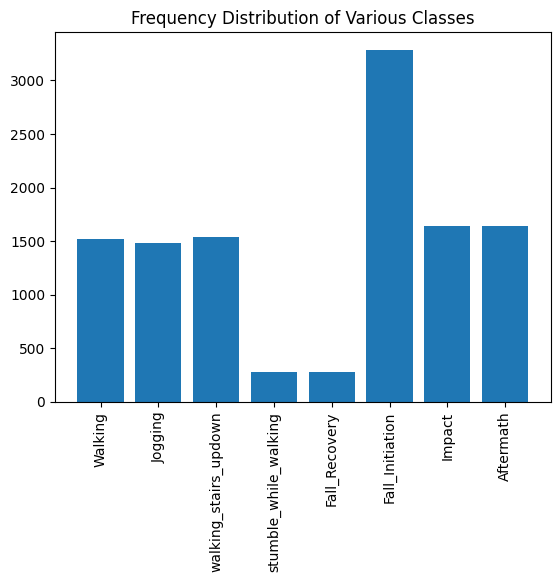

In [6]:
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Various Classes")
plt.xticks(rotation=90)

In [7]:
label = to_categorical(label, n_classes)
print("Shape of Label :", label.shape)
label

Shape of Label : (11674, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [8]:
final_data = zscore(final_data, axis=1)
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [9]:
I_Shape = final_data.shape[1:]
I_Shape

(200, 6)

In [10]:
def selective_kernel_conv(inputs, kernel_sizes, filters, use_bn=True, dropout_rate=0.3):
    conv_outputs = []
    for size in kernel_sizes:
        conv_output = Conv1D(filters=filters, kernel_size=size, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)
        if use_bn:
            conv_output = BatchNormalization()(conv_output)
        conv_outputs.append(conv_output)

    if len(conv_outputs) > 1:
        combined_output = Add()(conv_outputs)
    else:
        combined_output = conv_outputs[0]

    excitation = GlobalAveragePooling1D()(combined_output)
    excitation = Dense(len(kernel_sizes), activation='relu')(excitation)
    excitation = Dense(filters, activation='sigmoid')(excitation)
    excitation = tf.expand_dims(excitation, axis=1)

    weighted_output = Multiply()([combined_output, excitation])

    if dropout_rate:
        weighted_output = Dropout(dropout_rate)(weighted_output)

    return weighted_output

def attention_block(inputs):
    attention_scores = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention_output = Multiply()([inputs, attention_scores])
    return attention_output

def ENSEMBLE(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = selective_kernel_conv(inputs, kernel_sizes=[3, 5, 7], filters=64, dropout_rate=0.3)
    x = attention_block(x)

    x = selective_kernel_conv(x, kernel_sizes=[3, 5, 7], filters=128, dropout_rate=0.3)
    x = attention_block(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
precisions = []
recalls = []
losses = []

Fold 1
Epoch 1/200
263/263 [==============================] - 14s 36ms/step - loss: 1.4836 - accuracy: 0.4653 - val_loss: 1.8212 - val_accuracy: 0.4379
Epoch 2/200
263/263 [==============================] - 9s 34ms/step - loss: 0.9237 - accuracy: 0.6844 - val_loss: 0.9997 - val_accuracy: 0.6627
Epoch 3/200
263/263 [==============================] - 9s 36ms/step - loss: 0.7696 - accuracy: 0.7446 - val_loss: 0.8328 - val_accuracy: 0.7195
Epoch 4/200
263/263 [==============================] - 9s 35ms/step - loss: 0.6901 - accuracy: 0.7783 - val_loss: 0.7782 - val_accuracy: 0.7248
Epoch 5/200
263/263 [==============================] - 9s 35ms/step - loss: 0.6391 - accuracy: 0.7923 - val_loss: 0.7658 - val_accuracy: 0.7366
Epoch 6/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5947 - accuracy: 0.8144 - val_loss: 0.8381 - val_accuracy: 0.6991
Epoch 7/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5696 - accuracy: 0.8205 - val_loss: 0.6282 - val_a

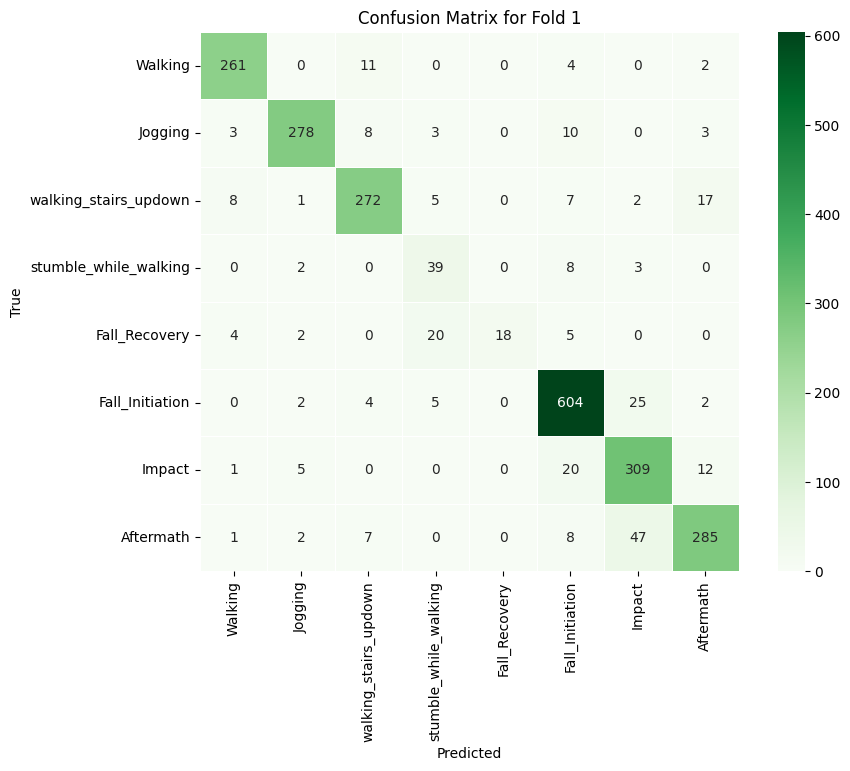

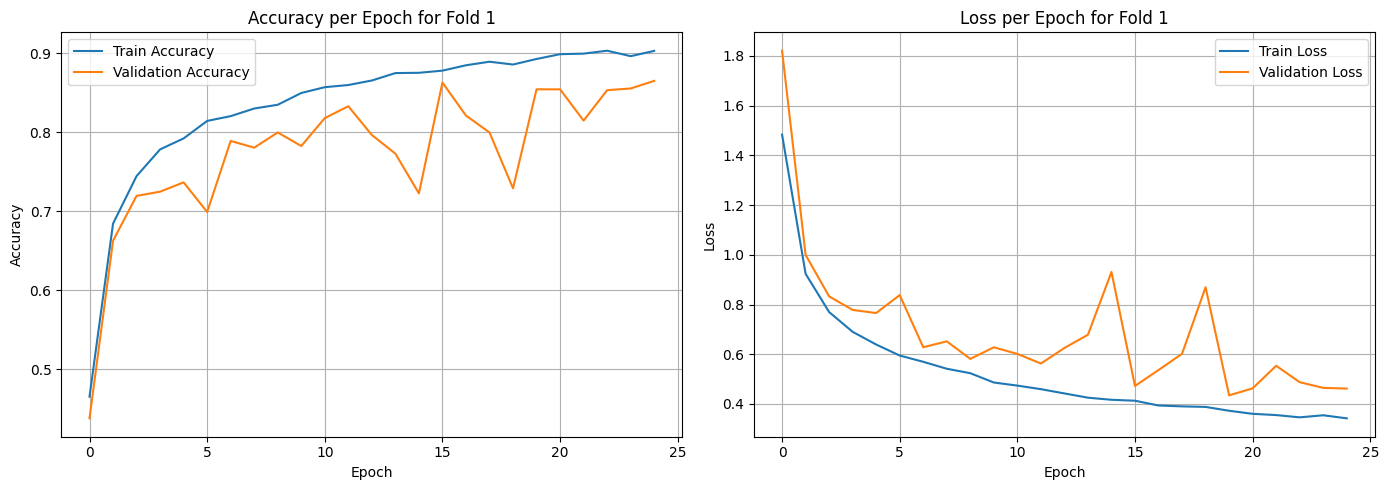

Fold 2
Epoch 1/200
263/263 [==============================] - 14s 36ms/step - loss: 1.6136 - accuracy: 0.4000 - val_loss: 2.0194 - val_accuracy: 0.0814
Epoch 2/200
263/263 [==============================] - 9s 34ms/step - loss: 1.0130 - accuracy: 0.6613 - val_loss: 1.0722 - val_accuracy: 0.6188
Epoch 3/200
263/263 [==============================] - 9s 33ms/step - loss: 0.8270 - accuracy: 0.7274 - val_loss: 0.8755 - val_accuracy: 0.6734
Epoch 4/200
263/263 [==============================] - 9s 34ms/step - loss: 0.7367 - accuracy: 0.7575 - val_loss: 0.6693 - val_accuracy: 0.7570
Epoch 5/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6779 - accuracy: 0.7811 - val_loss: 0.8103 - val_accuracy: 0.6927
Epoch 6/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6225 - accuracy: 0.8046 - val_loss: 0.7629 - val_accuracy: 0.7141
Epoch 7/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5907 - accuracy: 0.8196 - val_loss: 0.6180 - val_a

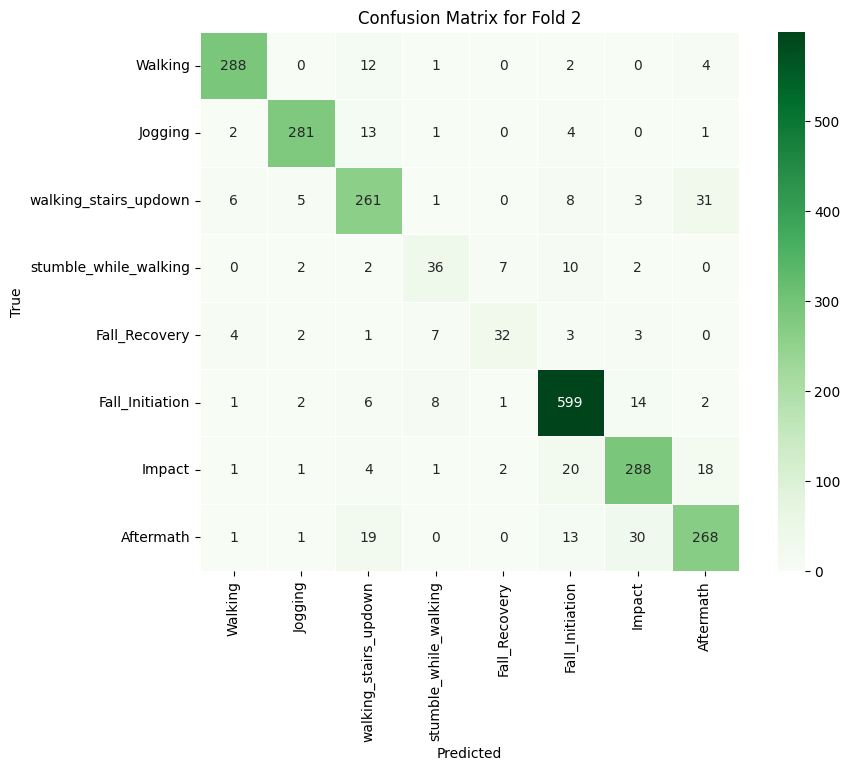

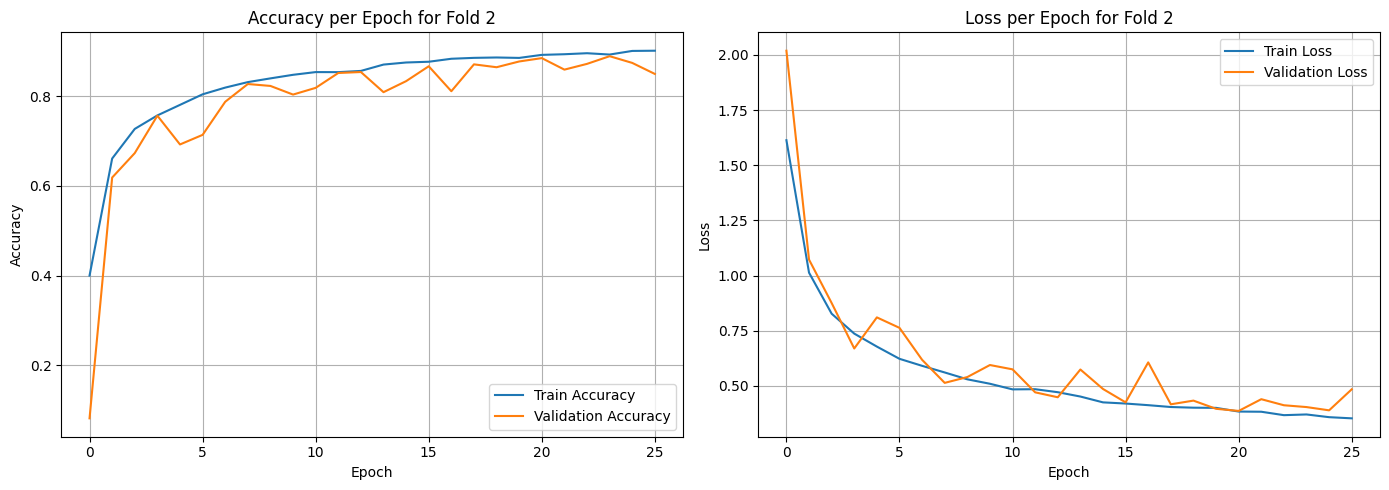

Fold 3
Epoch 1/200
263/263 [==============================] - 14s 37ms/step - loss: 1.5795 - accuracy: 0.4128 - val_loss: 1.6104 - val_accuracy: 0.4604
Epoch 2/200
263/263 [==============================] - 9s 34ms/step - loss: 1.0019 - accuracy: 0.6495 - val_loss: 1.0379 - val_accuracy: 0.6113
Epoch 3/200
263/263 [==============================] - 9s 34ms/step - loss: 0.8294 - accuracy: 0.7236 - val_loss: 0.9569 - val_accuracy: 0.6670
Epoch 4/200
263/263 [==============================] - 9s 34ms/step - loss: 0.7337 - accuracy: 0.7612 - val_loss: 0.7674 - val_accuracy: 0.7377
Epoch 5/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6801 - accuracy: 0.7842 - val_loss: 0.6493 - val_accuracy: 0.7805
Epoch 6/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6229 - accuracy: 0.8068 - val_loss: 0.5761 - val_accuracy: 0.8191
Epoch 7/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5785 - accuracy: 0.8243 - val_loss: 0.7430 - val_a

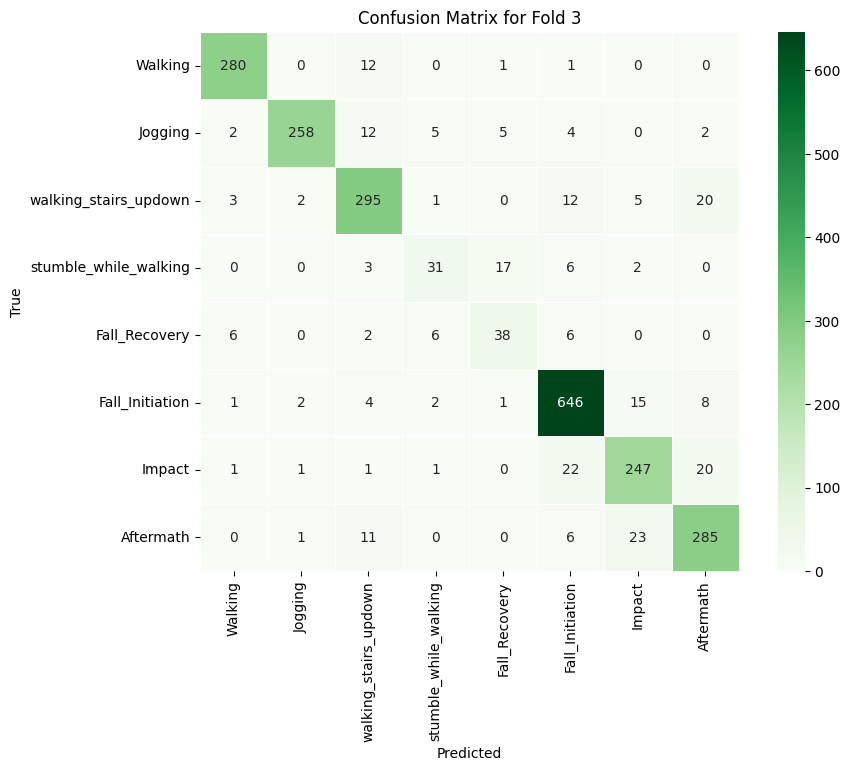

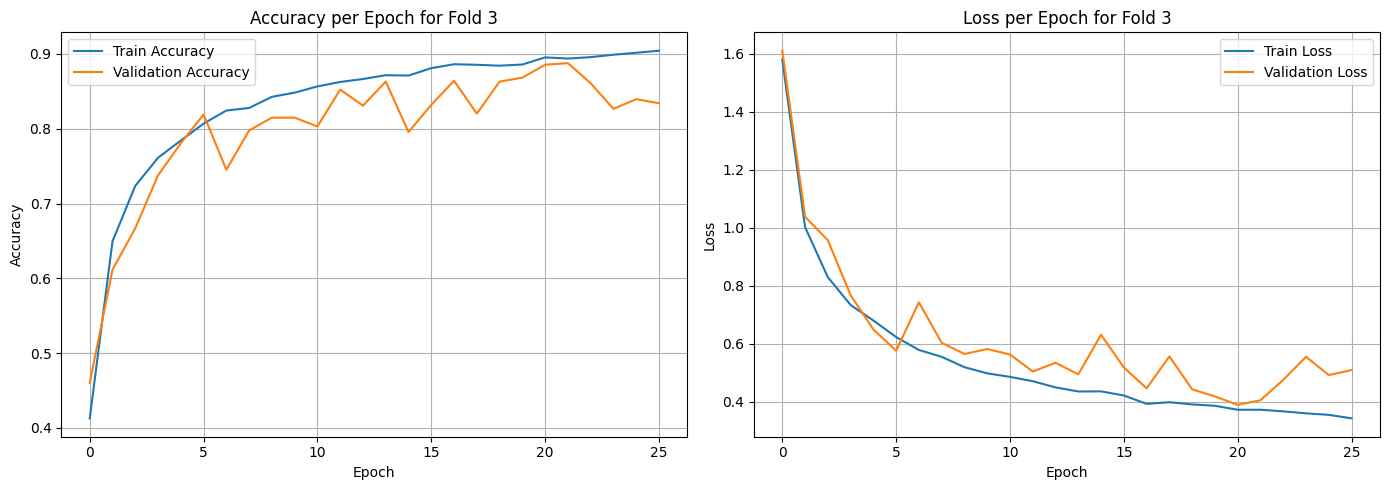

Fold 4
Epoch 1/200
263/263 [==============================] - 14s 38ms/step - loss: 1.5233 - accuracy: 0.4520 - val_loss: 1.8749 - val_accuracy: 0.2687
Epoch 2/200
263/263 [==============================] - 9s 34ms/step - loss: 0.9216 - accuracy: 0.7018 - val_loss: 1.2211 - val_accuracy: 0.5418
Epoch 3/200
263/263 [==============================] - 9s 34ms/step - loss: 0.7574 - accuracy: 0.7536 - val_loss: 0.8062 - val_accuracy: 0.7034
Epoch 4/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6817 - accuracy: 0.7775 - val_loss: 0.9210 - val_accuracy: 0.6595
Epoch 5/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6282 - accuracy: 0.8062 - val_loss: 0.6104 - val_accuracy: 0.7976
Epoch 6/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5804 - accuracy: 0.8209 - val_loss: 0.6066 - val_accuracy: 0.7901
Epoch 7/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5631 - accuracy: 0.8283 - val_loss: 0.6502 - val_a

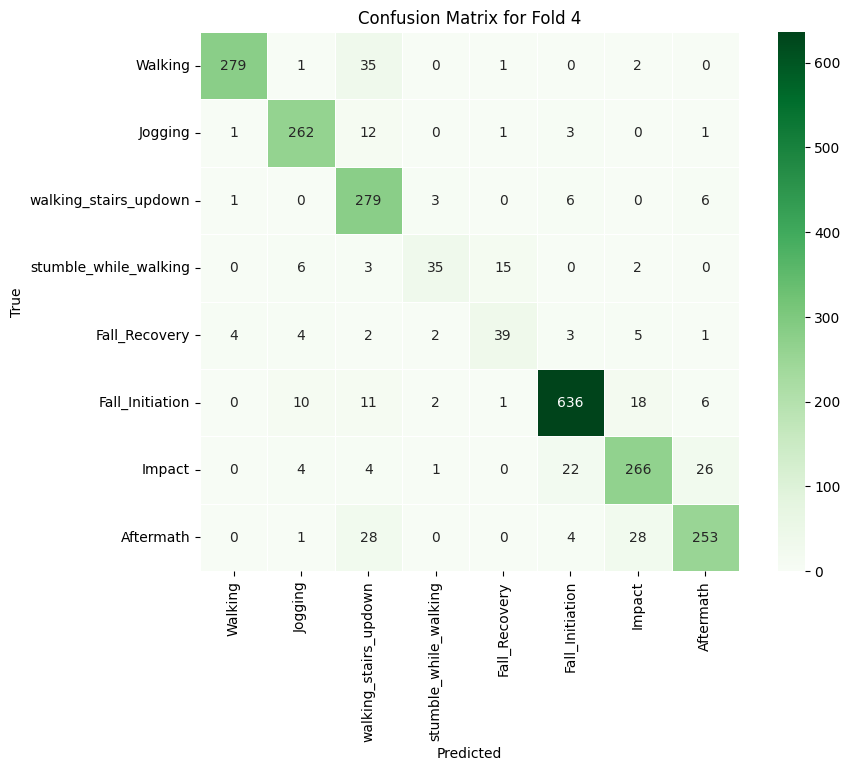

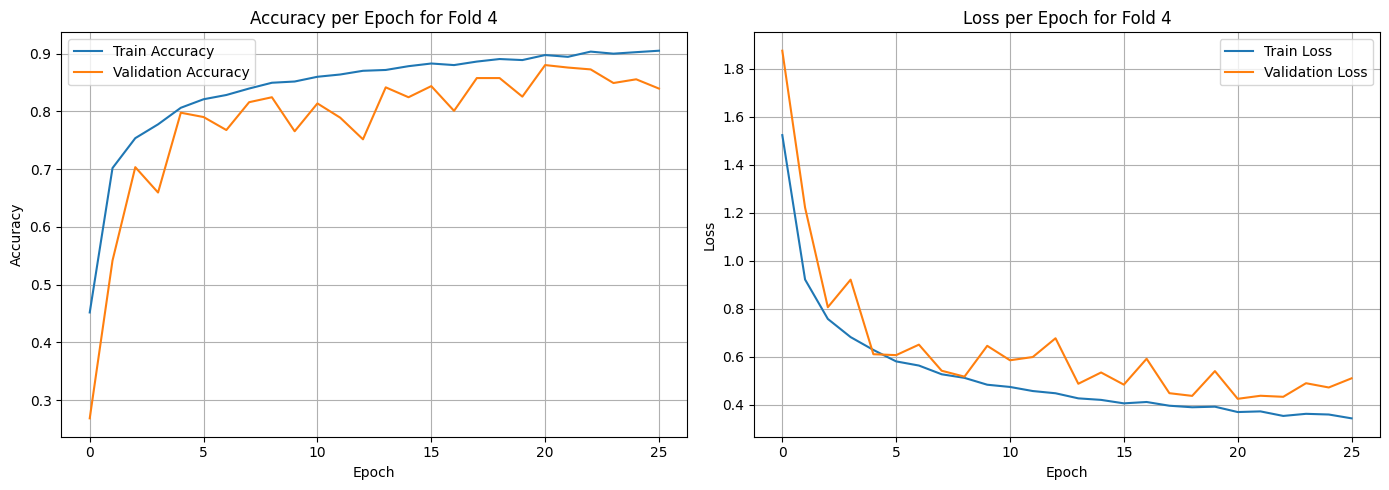

Fold 5
Epoch 1/200
263/263 [==============================] - 14s 37ms/step - loss: 1.6004 - accuracy: 0.4052 - val_loss: 1.8950 - val_accuracy: 0.1039
Epoch 2/200
263/263 [==============================] - 9s 34ms/step - loss: 1.0020 - accuracy: 0.6674 - val_loss: 1.1482 - val_accuracy: 0.5857
Epoch 3/200
263/263 [==============================] - 9s 34ms/step - loss: 0.7902 - accuracy: 0.7446 - val_loss: 0.8057 - val_accuracy: 0.7056
Epoch 4/200
263/263 [==============================] - 9s 34ms/step - loss: 0.7086 - accuracy: 0.7772 - val_loss: 0.7372 - val_accuracy: 0.7227
Epoch 5/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6738 - accuracy: 0.7900 - val_loss: 0.6307 - val_accuracy: 0.7741
Epoch 6/200
263/263 [==============================] - 9s 34ms/step - loss: 0.6152 - accuracy: 0.8093 - val_loss: 0.6795 - val_accuracy: 0.7634
Epoch 7/200
263/263 [==============================] - 9s 34ms/step - loss: 0.5860 - accuracy: 0.8194 - val_loss: 0.7240 - val_a

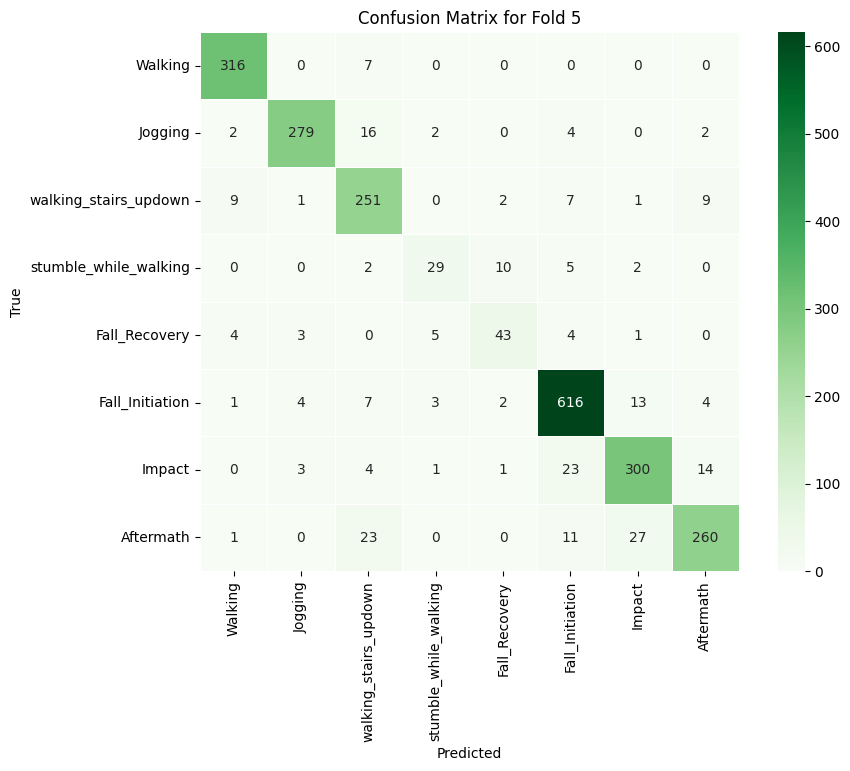

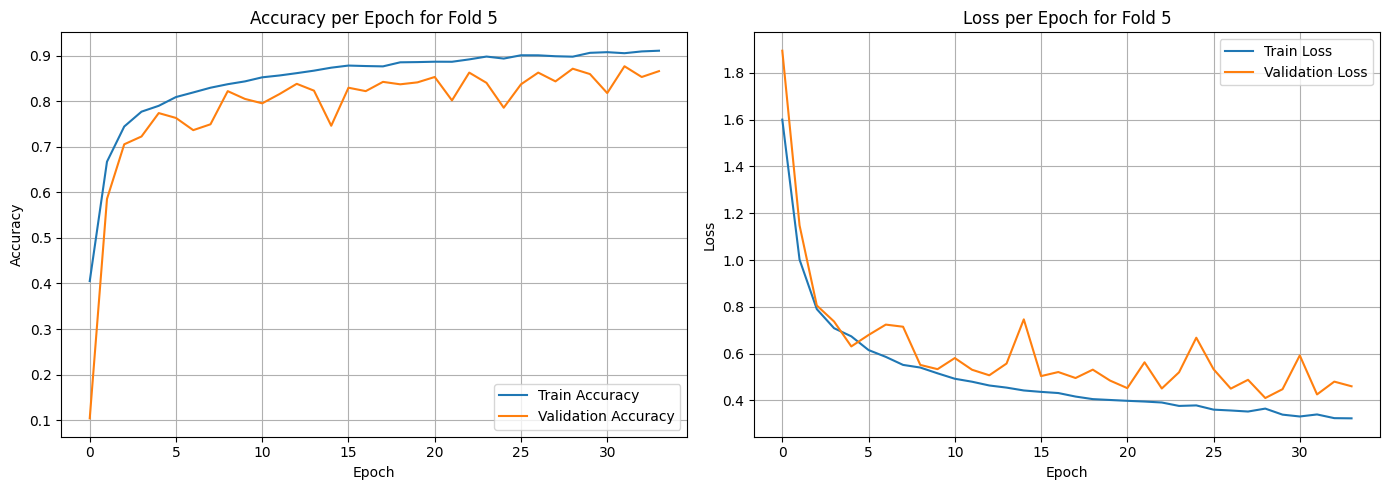

In [12]:
for train_index, test_index in kf.split(final_data):
    print(f"Fold {fold_no}")

    X_train, X_test = final_data[train_index], final_data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    model = ENSEMBLE(I_Shape, n_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=200,
        shuffle=True,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping]
    )

    loss, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    accuracies.append(accuracy)
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)

    predictions = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(pd.DataFrame(report).T)

    cm = confusion_matrix(y_true, y_pred)
    axis_labels = [label for label in class_labels]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, square = True, cmap='Greens', xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_no += 1

In [13]:
print("5-Fold Cross Validation Result")
print(f"Average Accuracy : {np.mean(accuracies):.4f}")
print(f"Average Precision : {np.mean(precisions):.4f}")
print(f"Average Recall : {np.mean(recalls):.4f}")
print(f"Average Loss : {np.mean(loss):.4f}")

5-Fold Cross Validation Result
Average Accuracy : 0.8859
Average Precision : 0.8881
Average Recall : 0.8859
Average Loss : 0.3750


In [14]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
h5_model = tf.keras.models.load_model('model.h5')
h5_loss, h5_accuracy = h5_model.evaluate(X_test, y_test)

73/73 [==============================] - 1s 10ms/step - loss: 0.3750 - accuracy: 0.8972


In [16]:
print(f'Model (.h5) Loss: {h5_loss:.4f}')
print(f'Model (.h5) Accuracy: {h5_accuracy:.4f}')

Model (.h5) Loss: 0.3750
Model (.h5) Accuracy: 0.8972


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [23]:
interpreter = tf.lite.Interpreter(model_path='model_quantized.tflite')
interpreter.allocate_tensors()

In [24]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
input_data = np.array(X_test, dtype=np.float32)
tflite_predictions = []

for i in range(input_data.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], input_data[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output)

In [26]:
tflite_predictions = np.array(tflite_predictions).squeeze()
tflite_accuracy = np.mean(np.argmax(tflite_predictions, axis=1) == np.argmax(y_test, axis=1))

print(f'Model (.tflite) Accuracy : {tflite_accuracy:.4f}')

Model (.tflite) Accuracy : 0.8916
